# Random Forest 

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score



In [77]:
data1 = pd.read_csv('Data_TaiwanEconomic_1999_2009.csv')


# 1)Feature Selection with Feature Importance

In [79]:
binary_cols = []

for col in data1.columns:
    if data1[col].nunique() == 2:
        binary_cols.append(col)

print(f'There are {len(binary_cols)} binary columns.')   
print(f'They are: {binary_cols}.')

There are 2 binary columns.
They are: ['Bankrupt?', ' Liability-Assets Flag'].


## 2)Feature Selection with Feature Importance

In [81]:
X = data1.drop('Bankrupt?', axis=1)
y = data1['Bankrupt?']

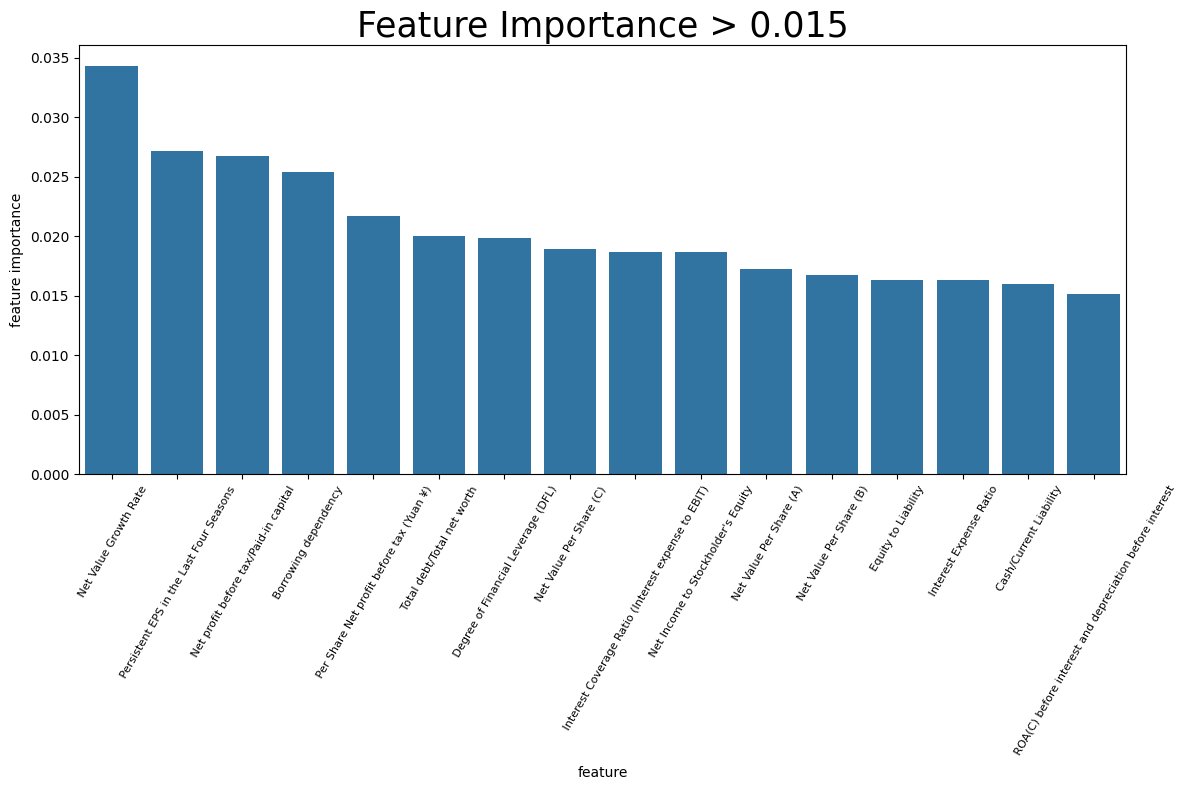

In [82]:
# Random Forest Model
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

# To sort the index in descending order, I multiply 'rf.feature_importances_' by -1
sorted_idx = (-rf.feature_importances_).argsort()

list_of_tuples = list(zip(X.columns[sorted_idx],
                          rf.feature_importances_[sorted_idx]))

feat_importance = pd.DataFrame(list_of_tuples,
                  columns=['feature', 'feature importance'])

fig = plt.figure(figsize=(12,8))

fig = sns.barplot(data=feat_importance[feat_importance['feature importance'] > 0.015], x='feature', y='feature importance')
plt.title('Feature Importance > 0.015',fontsize=25)
plt.xticks(fontsize=8,rotation=60)

plt.tight_layout()

In [83]:
col_001 = feat_importance[feat_importance['feature importance'] > 0.01]['feature'].to_list()

col_02 = feat_importance[feat_importance['feature importance'] > 0.02]['feature'].to_list()

print('Features with importance > 0.01: ')
print(col_001)
print()
print('Features with importance > 0.02: ')
print(col_02)

Features with importance > 0.01: 
[' Net Value Growth Rate', ' Persistent EPS in the Last Four Seasons', ' Net profit before tax/Paid-in capital', ' Borrowing dependency', ' Per Share Net profit before tax (Yuan ¥)', ' Total debt/Total net worth', ' Degree of Financial Leverage (DFL)', ' Net Value Per Share (C)', ' Interest Coverage Ratio (Interest expense to EBIT)', " Net Income to Stockholder's Equity", ' Net Value Per Share (A)', ' Net Value Per Share (B)', ' Equity to Liability', ' Interest Expense Ratio', ' Cash/Current Liability', ' ROA(C) before interest and depreciation before interest', ' Interest-bearing debt interest rate', ' Net Income to Total Assets', ' Working Capital/Equity', ' Cash/Total Assets', ' Inventory/Working Capital', ' Continuous interest rate (after tax)', ' Liability to Equity', ' Total income/Total expense', ' Fixed Assets Turnover Frequency', ' Non-industry income and expenditure/revenue', ' Revenue per person', ' Pre-tax net Interest Rate', ' Debt ratio %

In [84]:
X[col_02].head()

,Net Value Growth Rate,Persistent EPS in the Last Four Seasons,Net profit before tax/Paid-in capital,Borrowing dependency,Per Share Net profit before tax (Yuan ¥),Total debt/Total net worth
0,0.000327,0.169141,0.137757,0.390284,0.138736,0.021266
1,0.000443,0.208944,0.168962,0.376760,0.169918,0.012502
2,0.000396,0.180581,0.148036,0.379093,0.142803,0.021248
3,0.000382,0.193722,0.147561,0.379743,0.148603,0.009572
4,0.000439,0.212537,0.167461,0.375025,0.168412,0.005150


## 3)Feature Selection with Variance Threshold

The variance threshold method removes all those features whose variance does not meet some threshold. By default, it removes all zero-variance features, i.e., features with the same value in all samples under the assumption that the features with a higher variance may contain more useful information.

For quasi-constant features, that have the same value for a very large subset, using a threshold of 0.01 would mean dropping the column where 99% of the values are similar.

In [118]:
var_thr = VarianceThreshold(threshold = 0.1) 
var_thr.fit(X)

var_thr.get_support()

array([False, False, False, False, False, False, False, False, False,
       False,  True,  True, False,  True, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True,  True, False, False,  True,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True, False,  True, False,  True, False,
       False, False, False,  True,  True, False, False, False,  True,
       False, False, False,  True, False, False, False,  True,  True,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False])

The values in the output mean:

True: High Variance
False: Low Variance
linkcode
I am dropping the columns that are 90% or more similar.

In [121]:
concol = [column for column in X.columns if column not in X.columns[var_thr.get_support()]]

for features in concol:
    print(features)

 ROA(C) before interest and depreciation before interest
 ROA(A) before interest and % after tax
 ROA(B) before interest and depreciation after tax
 Operating Gross Margin
 Realized Sales Gross Margin
 Operating Profit Rate
 Pre-tax net Interest Rate
 After-tax net Interest Rate
 Non-industry income and expenditure/revenue
 Continuous interest rate (after tax)
 Cash flow rate
 Tax rate (A)
 Net Value Per Share (B)
 Net Value Per Share (A)
 Net Value Per Share (C)
 Persistent EPS in the Last Four Seasons
 Cash Flow Per Share
 Operating Profit Per Share (Yuan ¥)
 Per Share Net profit before tax (Yuan ¥)
 Realized Sales Gross Profit Growth Rate
 Operating Profit Growth Rate
 After-tax Net Profit Growth Rate
 Regular Net Profit Growth Rate
 Continuous Net Profit Growth Rate
 Total Asset Return Growth Rate Ratio
 Cash Reinvestment %
 Interest Expense Ratio
 Debt ratio %
 Net worth/Assets
 Long-term fund suitability ratio (A)
 Borrowing dependency
 Contingent liabilities/Net worth
 Operating

## 4.1)Classification with the 'Feature Importance' Dataset

In [99]:
def get_test_scores(model_name:str,preds,y_test_data):
    
    accuracy  = accuracy_score(y_test_data,preds)
    precision = precision_score(y_test_data,preds,average='macro')
    recall    = recall_score(y_test_data,preds,average='macro')
    f1        = f1_score(y_test_data,preds,average='macro')

    table = pd.DataFrame({'model': [model_name],'precision': [precision],'recall': [recall],
                          'F1': [f1],'accuracy': [accuracy]})

    return table
    
X_train, X_test, y_train, y_test = train_test_split(X[col_02], y, test_size=0.3, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

rf_test_preds_FI = rf.predict(X_test)

rf_test_results_FI = get_test_scores('Random Forest (with Feature Importance)', rf_test_preds_FI, y_test)
rf_test_results_FI 

,model,precision,recall,F1,accuracy
0,Random Forest (with Feature Importance),0.780942,0.599769,0.643226,0.964321


## 4.2)Classification with the 'Forward Feature Selection' Dataset

In [125]:
selected_features_forw = X.columns.tolist()  # Modify based on actual feature selection logic
X_train, X_test, y_train, y_test = train_test_split(X[selected_features_forw], y, test_size=0.3, random_state=42)
rf.fit(X_train, y_train)

rf_test_preds_FFS = rf.predict(X_test)

rf_test_results_FFS = get_test_scores('Random Forest (with Forward Feature Selection)', rf_test_preds_FFS, y_test)

rf_test_results_FFS

,model,precision,recall,F1,accuracy
0,Random Forest (with Forward Feature Selection),0.834205,0.588219,0.634094,0.965787


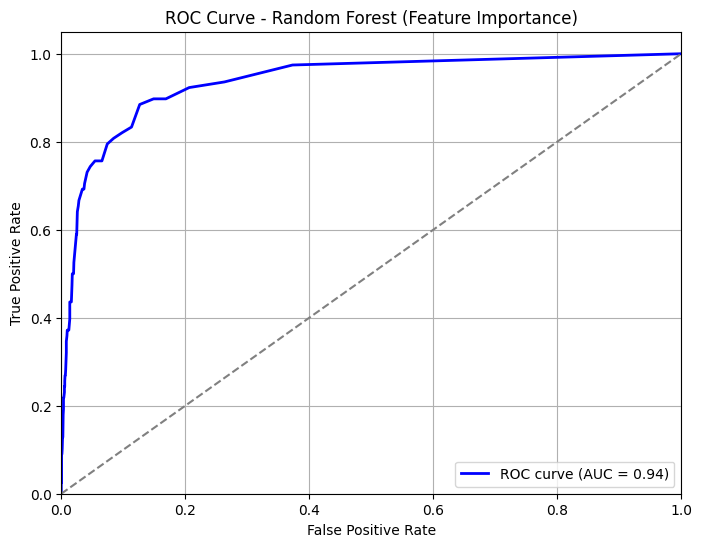

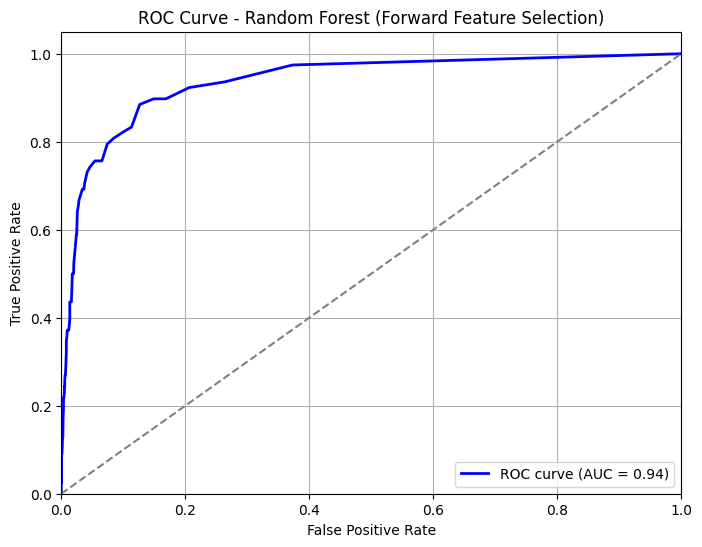

In [129]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to plot ROC Curve
def plot_roc_curve(y_test, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_probs)  # Compute FPR, TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

# Get probability scores for Feature Importance Model
rf_test_probs_FI = rf.predict_proba(X_test)[:, 1]  # Probabilities for positive class
plot_roc_curve(y_test, rf_test_probs_FI, "Random Forest (Feature Importance)")

# Get probability scores for Forward Feature Selection Model
rf_test_probs_FFS = rf.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, rf_test_probs_FFS, "Random Forest (Forward Feature Selection)")
